<a href="https://colab.research.google.com/github/danieltebor/cs4267-deepfake-detector-project/blob/main/cs4267_deepfake_detector_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 4267 Section 01 - Fake Image Detection Project

## Setup

All required modules are imported and dependencies downloaded. PyTorch is used as the main machine learning framework. SkLearn and MatPlotLib are used for evaluating and graphing results.

### Repositories

In [1]:
!git clone https://github.com/danieltebor/cs4267-deepfake-detector-project.git

Cloning into 'cs4267-deepfake-detector-project'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 60 (delta 11), reused 50 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 20.67 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (11/11), done.


### Imports

In [2]:
import copy
import os
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from safetensors.torch import save_file

import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from matplotlib import pyplot as plt
import seaborn as sns

sys.path.append('cs4267-deepfake-detector-project')
from models.deepfake_detector_net import DeepfakeDetectorNet

### Downloads

In [3]:
# Download dataset. https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
!if [ ! -d "Dataset" ]; then \
    kaggle datasets download manjilkarki/deepfake-and-real-images && \
    7z x deepfake-and-real-images.zip -aos -o. && \
    rm deepfake-and-real-images.zip; \
fi

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [02:19<00:00, 13.7MB/s]
100% 1.68G/1.68G [02:19<00:00, 12.9MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,16 CPUs AMD Ryzen 7 7800X3D 8-Core Processor            (A60F12),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1808722718 bytes (1725 MiB)

Extracting archive: deepfake-and-real-images.zip
  2% 4096 Open              --
Path = deepfake-and-real-images.zip
Type = zip
Physical Size = 1808722718
64-bit = +

  0%      0% 843 - Dataset/Test/Fake/fake_1757.jpg                                            0% 1385           1% 1784 - Dataset/Test/Fake/fake_2603.jpg

## Dataset

The [dataset](https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images) is a set of real and deepfaked images split into training, validation, and testing sets. The table shows the number of samples for each set:

| Training | Validation | Testing |
|----------|------------|---------|
| 1400002  | 39428      | 10605   |

The samples are RGB images of size 256x256. For preprocessing, we resize the images to 224x224, convert to a tensor, and normalize the images to the mean and standard deviation of the [ImageNet](https://www.image-net.org/) dataset. For the training set only, we apply the following augmentations: random 10 degree rotation, 10% horizontal and vertical translation, 90% to 110% scaling, and color jitter. The samples are aranged into batches of 256.

In [4]:
# Define dirs.
data_dir = 'Dataset'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Validation'
test_dir = f'{data_dir}/Test'

# Define transforms for data.
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# Transform image directories into training, validation, and testing datasets.
train_dataset = ImageFolder(train_dir, transform=aug_transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Print dataset info.
print('Sample Shape: ', train_dataset[0][0].size())
print('Train Samples:', len(train_dataset))
print('Validation Samples:', len(val_dataset))
print('Test Samples:', len(test_dataset))
print('Classes:', train_dataset.classes)

# Wrap datasets in data loaders.
batch_size = 256
num_workers = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True) # Enable shuffle to add random sampling.
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


Sample Shape:  torch.Size([3, 224, 224])
Train Samples: 140002
Validation Samples: 39428
Test Samples: 10905
Classes: ['Fake', 'Real']


## Training and Evaluation Scripts

### Training

We optimize the model with the AdamW optimizer with a defined lr and weight decay. The validation set is used each epoch to assess the model's performance on non-training data. The weights from the epoch with the best validation loss are kept and loaded once training is completed.

In [5]:
def train_model(
    model: nn.Module,
    device: str,
    lr: float = 1e-4,
    weight_decay: float = 0.0,
    num_epochs: int = 10,
):
    global train_loader, val_loader

    device = 'cuda'
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-8)
    scaler = GradScaler()

    best_loss = float('inf')
    best_weights = copy.deepcopy(model.state_dict())

    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0

        model.train()
        train_pbar = tqdm(train_loader, desc='Training', leave=False)
        for x, y in train_pbar:
            x, y = x.to(device), y.to(device)
            y = y.float()

            optimizer.zero_grad()

            # Calculate predicted y using the model and optimize.
            with autocast(device_type=device):
                y_pred = model(x)
                loss = F.binary_cross_entropy_with_logits(y_pred.view(-1), y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track loss.
            loss = loss.item()
            total_train_loss += loss
            train_pbar.set_postfix(loss=f'{loss:.6f}')

        model.eval()
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc='Validation', leave=False)
            for x, y in val_pbar:
                x, y = x.to(device), y.to(device)
                y = y.float()

                # Calculate predicted y.
                with autocast(device_type=device):
                    y_pred = model(x)
                    loss = F.binary_cross_entropy_with_logits(y_pred.view(-1), y)

                # Track loss.
                loss = loss.item()
                total_val_loss += loss
                val_pbar.set_postfix(loss=f'{loss:.6f}')

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch: {epoch + 1}, Train loss: {avg_train_loss:.6f}, Val loss: {avg_val_loss:.6f}')

        epoch_train_losses.append(avg_train_loss)
        epoch_val_losses.append(avg_val_loss)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)
    save_file(best_weights, 'deepfake-detector-net.safetensors')

    plt.figure()
    plt.plot(epoch_train_losses, label='Training Loss')
    plt.plot(epoch_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close()

### Evaluation

Metrics used to evaluate the model include accuracy, F1 score, a confusion matrix, and an ROC curve.

In [6]:
def eval_model(model: nn.Module, device: str):
    global test_loader

    model.eval()
    model = model.to(device)

    preds = []
    labels = []

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing', leave=False)
        for x, y in test_pbar:
            x, y = x.to(device), y.to(device)

            # Predict real or fake image.
            y_pred = model(x)
            y_pred = F.sigmoid(y_pred)
            y_pred = y_pred.view(-1) > 0.5

            preds.append(y_pred.cpu().numpy())
            labels.append(y.cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    time.sleep(1) # Fixes console output bug.

    accuracy = accuracy_score(labels, preds)
    print(f'Accuracy: {accuracy:.6f}')

    f1 = f1_score(labels, preds)
    print(f'F1 Score: {f1:.6f}')

    conf_matrix = confusion_matrix(labels, preds)
    conf_matrix = conf_matrix[::-1, ::-1]
    print('Confusion Matrix:')
    plt.figure()
    sns.heatmap(conf_matrix.T, annot=True, fmt='d', cmap='Blues')
    plt.gca().xaxis.set_label_position('top')
    plt.gca().xaxis.tick_top()
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.gca().set_xticklabels([1, 0])
    plt.gca().set_yticklabels([1, 0], rotation=0)
    plt.show()
    plt.close()

    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    print('ROC Curve:')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    plt.close()

## Custom Deepfake Detector Model


We implement a custom ConvNet based on the modern [ConvNeXt](https://arxiv.org/pdf/2201.03545) architecture. The network uses a convolutional layer with a 4x4 kernel and stride of 4 to extract patches from the input. The patches are then fed through a series of inverted bottlenecks to extract features in a parameter-efficient way. Layer normalization is used throughout to stabilize the network. The extracted features are pooled, flattened and then fed into a fully connected layer to predict real or deepfaked images. The resulting architecture has 2,298,512 learnable parameters.

In [10]:
deepfake_detector = DeepfakeDetectorNet()

We train the model using an lr of 1e-4 and a weight decay of 1e-8 for 20 epochs. These hyperparameters were found to provide a smooth gradient descent.

Epoch: 1, Train loss: 0.603003, Val loss: 0.616958


Epoch: 2, Train loss: 0.559085, Val loss: 0.594242


Epoch: 3, Train loss: 0.527227, Val loss: 0.545124


Epoch: 4, Train loss: 0.498148, Val loss: 0.551033


Epoch: 5, Train loss: 0.475922, Val loss: 0.550127


Epoch: 6, Train loss: 0.454706, Val loss: 0.526727


Epoch: 7, Train loss: 0.433023, Val loss: 0.514528


Epoch: 8, Train loss: 0.412573, Val loss: 0.466355


Epoch: 9, Train loss: 0.390702, Val loss: 0.399486


Epoch: 10, Train loss: 0.371470, Val loss: 0.442719


Epoch: 11, Train loss: 0.350041, Val loss: 0.409397


Epoch: 12, Train loss: 0.333391, Val loss: 0.441718


Epoch: 13, Train loss: 0.319442, Val loss: 0.347860


Epoch: 14, Train loss: 0.307690, Val loss: 0.363385


Epoch: 15, Train loss: 0.294088, Val loss: 0.377632


Epoch: 16, Train loss: 0.283019, Val loss: 0.351363


Epoch: 17, Train loss: 0.272610, Val loss: 0.303312


Epoch: 18, Train loss: 0.266343, Val loss: 0.345441


Epoch: 19, Train loss: 0.255216, Val loss: 0.308445


Epoch: 20, Train loss: 0.246500, Val loss: 0.388027


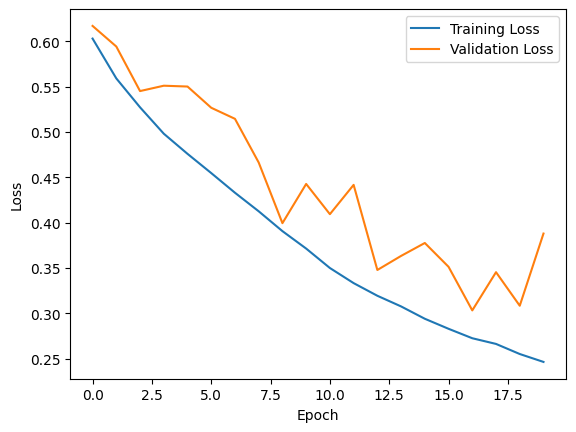

In [11]:
train_model(deepfake_detector, 'cuda', 1e-4, 1e-8, 20)
time.sleep(1) # Fixes console output bug.

The model is then evaluated.

Accuracy: 0.830812
F1 Score: 0.834781
Confusion Matrix:


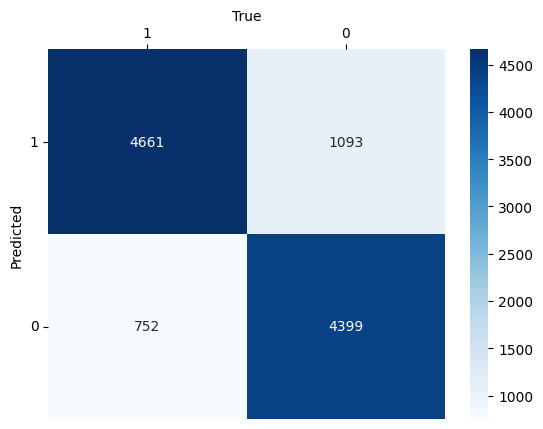

ROC Curve:


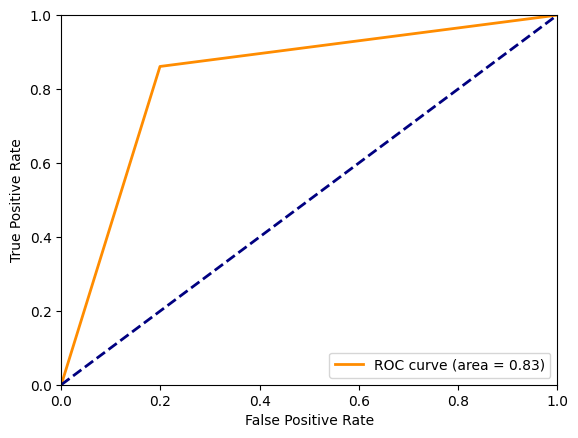

In [12]:
eval_model(deepfake_detector, 'cuda')

## MobileNet

For comparision, we also train and evaluate the MobileNetv3-Small architecture. This architecture has 2.5M parameters, which is similar to our custom model.

In [13]:
mobilenet = models.mobilenet_v3_small(num_classes=1)

We train the model using an lr of 1e-4 and a weight decay of 1e-8 for 20 epochs. These hyperparameters were found to provide a smooth gradient descent.

Epoch: 1, Train loss: 0.625727, Val loss: 0.703180


Epoch: 2, Train loss: 0.529591, Val loss: 0.540829


Epoch: 3, Train loss: 0.484903, Val loss: 0.509483


Epoch: 4, Train loss: 0.457287, Val loss: 0.525278


Epoch: 5, Train loss: 0.430580, Val loss: 0.530953


Epoch: 6, Train loss: 0.407059, Val loss: 0.529254


Epoch: 7, Train loss: 0.386374, Val loss: 0.486131


Epoch: 8, Train loss: 0.362065, Val loss: 0.476268


Epoch: 9, Train loss: 0.342948, Val loss: 0.452436


Epoch: 10, Train loss: 0.323485, Val loss: 0.386324


Epoch: 11, Train loss: 0.305191, Val loss: 0.439354


Epoch: 12, Train loss: 0.288073, Val loss: 0.399801


Epoch: 13, Train loss: 0.273718, Val loss: 0.440397


Epoch: 14, Train loss: 0.259567, Val loss: 0.353029


Epoch: 15, Train loss: 0.247246, Val loss: 0.345447


Epoch: 16, Train loss: 0.238222, Val loss: 0.338234


Epoch: 17, Train loss: 0.225997, Val loss: 0.360068


Epoch: 18, Train loss: 0.218528, Val loss: 0.371667


Epoch: 19, Train loss: 0.208361, Val loss: 0.323801


Epoch: 20, Train loss: 0.201488, Val loss: 0.399499


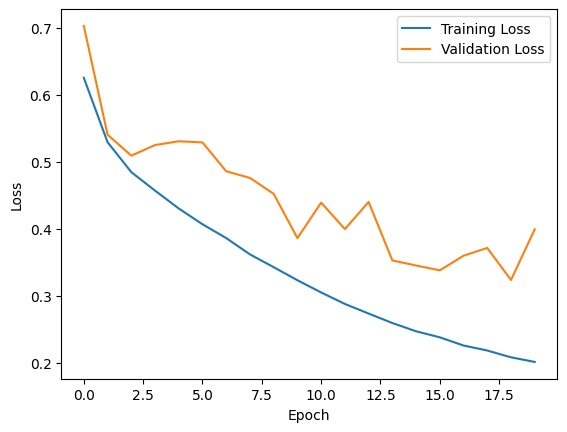

In [14]:
train_model(mobilenet, 'cuda', 1e-4, 1e-8, 20)
time.sleep(1) # Fixes console output bug.

The model is then evaluated.

Accuracy: 0.791380
F1 Score: 0.804872
Confusion Matrix:


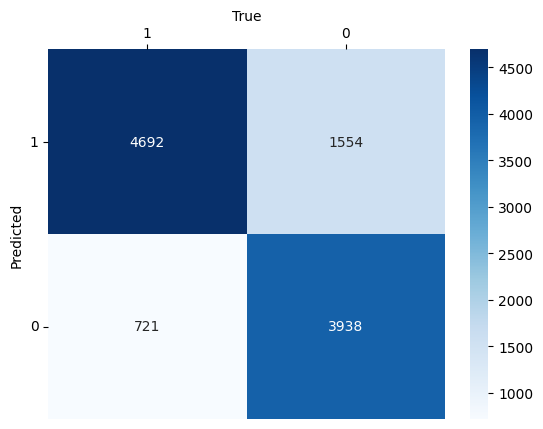

ROC Curve:


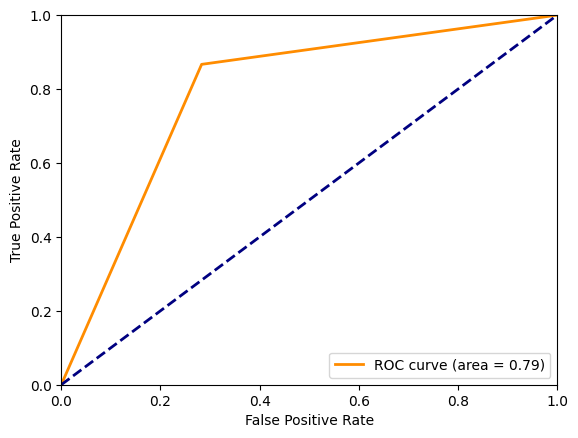

In [15]:
eval_model(mobilenet, 'cuda')